### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 5


### Дисциплина: Методы машинного обучения

##### Студент:  Щербак Маргарита Романовна
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант №20

1. Набор данных stl10

2. Классы с метками 5,7,9

3. Требования к архитектуре сети MLP:

  - Кол-во скрытых слоев 6

  - Кол-во нейронов 50 в каждом нечетном скрытом слое, 40 в каждом четном скрытом слое

  - Оптимизатор Adam

  - Функция активации в скрытых слоях elu

  - Регуляризация L2 в каждом нечетном скрытом слое

4. Требования к архитектуре сети CNN:

  - Кол-во слоев пулинга 3

  - Количество фильтров в сверточных слоях 16

  - Размеры фильтра 4х4

  - Оптимизатор SGD

  - Функция активации в сверточных слоях tanh

  - Функция активации в скрытых плотных слоях selu

  - Слои dropout после каждого скрытого плотного слоя

5. Показатель качества бинарной классификации:

- индекс Жаккара, равный TP/(TP + FP + FN)

6. Показатель качества многоклассовой классификации:

- максимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.

**Задание 1**   
Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.

Импортирую библиотеки, которые мне понадобятся для выполнения этой лабораторной работы.

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [ ]:
# Загрузка набора данных STL-10
ds, info = tfds.load('stl10', split=['train', 'test'], with_info=True)
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])

# Вывод информации о наборе данных
print(info)

tfds.core.DatasetInfo(
    name='stl10',
    full_name='stl10/1.0.0',
    description="""
    The STL-10 dataset is an image recognition dataset for developing unsupervised
    feature learning, deep learning, self-taught learning algorithms. It is inspired
    by the CIFAR-10 dataset but with some modifications. In particular, each class
    has fewer labeled training examples than in CIFAR-10, but a very large set of
    unlabeled examples is provided to learn image models prior to supervised
    training. The primary challenge is to make use of the unlabeled data (which
    comes from a similar but different distribution from the labeled data) to build
    a useful prior. All images were acquired from labeled examples on ImageNet.
    """,
    homepage='http://ai.stanford.edu/~acoates/stl10/',
    data_dir='/root/tensorflow_datasets/stl10/1.0.0',
    file_format=tfrecord,
    download_size=2.46 GiB,
    dataset_size=1.86 GiB,
    features=FeaturesDict({
        'image': Image(shape=

**Задание 2**   
Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageOps
from matplotlib import rcParams

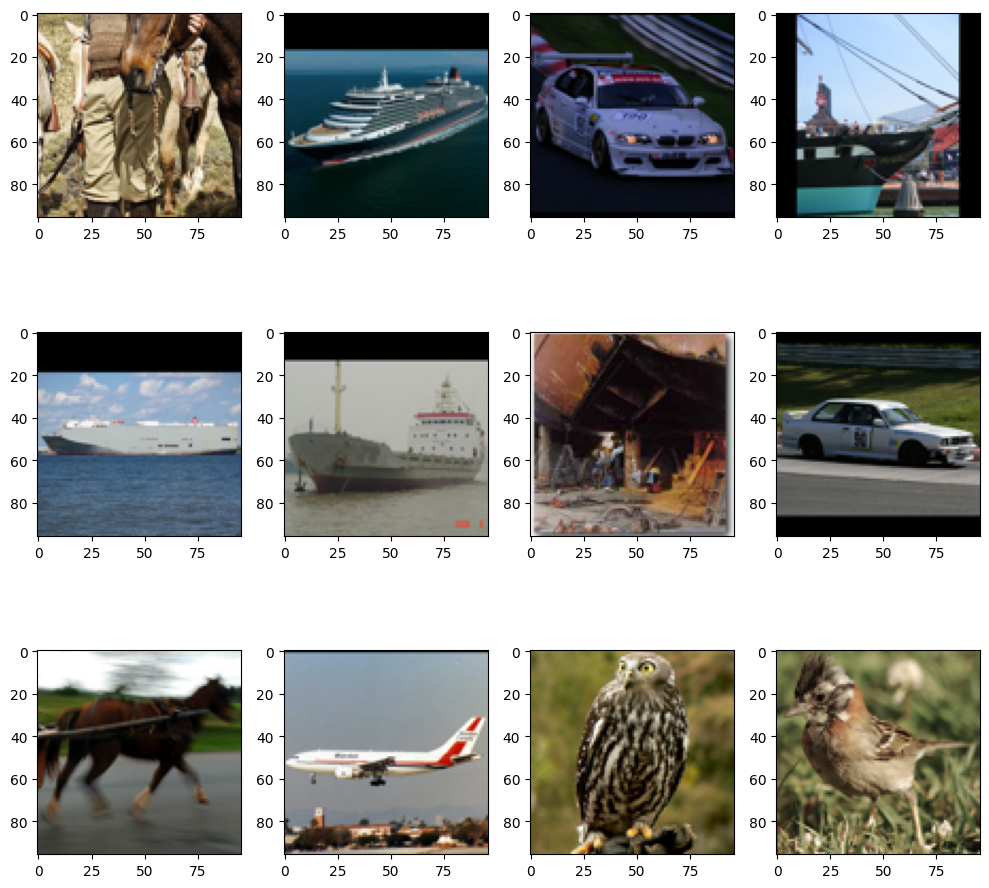

In [ ]:
plt.figure(figsize=(10, 10))
num_rows = 3
num_cols = 4
total_images = num_rows * num_cols

for i in range(total_images):
    # Случайным образом выбираем индекс изображения
    idx = random.randint(0, len(df_train) - 1)
    # Получаем изображение и метку
    image = df_train.iloc[idx]['image']
    label = df_train.iloc[idx]['label']
    # Выводим изображение
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(image)

plt.tight_layout()  # Автоматическая расстановка изображений
plt.show()


**Задание 3**   
Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми. Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании). Отследите обучение нейронных сетей и укажите, на сколько процентов снизились в результате обучения потери по отношению к потерям на первой эпохе обучения. Оцените результаты обучения нейронных сетей.

In [ ]:
# Фильтрация по нужным меткам
df_train_filtered = df_train[df_train['label'].isin([5, 7])]
df_test_filtered = df_test[df_test['label'].isin([5, 7])]

# Замена меток на бинарные значения
label_map = {5: 1, 7: 0}
df_train_filtered['label'] = df_train_filtered['label'].map(label_map)
df_test_filtered['label'] = df_test_filtered['label'].map(label_map)

In [ ]:
# Конвертация изображений и меток в numpy массивы
train_labels = df_train_filtered['label'].to_numpy(dtype=np.float32)
test_labels = df_test_filtered['label'].to_numpy(dtype=np.float32)

train_images = np.zeros(shape=(df_train_filtered.shape[0], 96, 96, 3), dtype=np.float32)
test_images = np.zeros(shape=(df_test_filtered.shape[0], 96, 96, 3), dtype=np.float32)

In [ ]:
for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train.iloc[idx]['image']))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test.iloc[idx]['image']))

train_images.shape, test_images.shape

((1000, 96, 96, 3), (1600, 96, 96, 3))

In [ ]:
train_images /= 255.0
test_images /= 255.0

In [ ]:
# MLP
tf.random.set_seed(42)

mlp_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mlp_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 27648)             0         
                                                                 
 dense_112 (Dense)           (None, 50)                1382450   
                                                                 
 dense_113 (Dense)           (None, 40)                2040      
                                                                 
 dense_114 (Dense)           (None, 50)                2050      
                                                                 
 dense_115 (Dense)           (None, 40)                2040      
                                                                 
 dense_116 (Dense)           (None, 50)                2050      
                                                                 
 dense_117 (Dense)           (None, 40)              

In [ ]:
# Определение метрики Жаккара TP/(TP + FP + FN)
def jaccard_index(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)

mlp_model.compile( loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[ tf.keras.metrics.BinaryAccuracy(name='accuracy'),jaccard_index])

# Обучение MLP
mlp_history = mlp_model.fit(train_images, train_labels, epochs=50,
    batch_size=128,
    validation_data=(test_images, test_labels))

Epoch 1/50
8/8 [==============================] - 4s 198ms/step - loss: 2.5735 - accuracy: 0.5320 - jaccard_index: 0.3380 - val_loss: 2.4045 - val_accuracy: 0.4963 - val_jaccard_index: 0.2719
Epoch 2/50
8/8 [==============================] - 1s 110ms/step - loss: 2.2793 - accuracy: 0.4870 - jaccard_index: 0.3022 - val_loss: 2.0887 - val_accuracy: 0.4806 - val_jaccard_index: 0.3215
Epoch 3/50
8/8 [==============================] - 1s 109ms/step - loss: 1.9787 - accuracy: 0.5050 - jaccard_index: 0.3369 - val_loss: 1.8392 - val_accuracy: 0.4794 - val_jaccard_index: 0.3131
Epoch 4/50
8/8 [==============================] - 1s 111ms/step - loss: 1.7540 - accuracy: 0.5040 - jaccard_index: 0.3318 - val_loss: 1.6550 - val_accuracy: 0.4819 - val_jaccard_index: 0.3372
Epoch 5/50
8/8 [==============================] - 1s 91ms/step - loss: 1.5952 - accuracy: 0.5080 - jaccard_index: 0.3339 - val_loss: 1.5362 - val_accuracy: 0.4913 - val_jaccard_index: 0.3452
Epoch 6/50
8/8 [=========================

Как мы видим, потери уменьшаются, доля верных ответов увеличивается. Индекс Жаккара тоже в итогое вырос, хотя несильно.

In [ ]:
# CNN
tf.random.set_seed(42)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), input_shape=(96, 96, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(50, activation='selu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(40, activation='selu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 93, 93, 16)        784       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 47, 47, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 44, 44, 16)        4112      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 22, 22, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 19, 19, 16)        4112      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 10, 10, 16)      

In [ ]:
cnn_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adamax(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'), jaccard_index])

# Обучение CNN
cnn_history = cnn_model.fit(train_images, train_labels, epochs=15, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/15
8/8 [==============================] - 17s 2s/step - loss: 0.7035 - accuracy: 0.5510 - jaccard_index: 0.3544 - val_loss: 0.7285 - val_accuracy: 0.5075 - val_jaccard_index: 0.2762
Epoch 2/15
8/8 [==============================] - 15s 2s/step - loss: 0.7037 - accuracy: 0.5310 - jaccard_index: 0.3290 - val_loss: 0.7042 - val_accuracy: 0.4881 - val_jaccard_index: 0.3419
Epoch 3/15
8/8 [==============================] - 14s 2s/step - loss: 0.6780 - accuracy: 0.5660 - jaccard_index: 0.3486 - val_loss: 0.7038 - val_accuracy: 0.4950 - val_jaccard_index: 0.3213
Epoch 4/15
8/8 [==============================] - 14s 2s/step - loss: 0.6743 - accuracy: 0.5730 - jaccard_index: 0.3456 - val_loss: 0.7045 - val_accuracy: 0.4944 - val_jaccard_index: 0.3307
Epoch 5/15
8/8 [==============================] - 14s 2s/step - loss: 0.6657 - accuracy: 0.6050 - jaccard_index: 0.3570 - val_loss: 0.7067 - val_accuracy: 0.4963 - val_jaccard_index: 0.3235
Epoch 6/15
8/8 [==============================] - 

Модель CNN плохо обучается. Были попытки изменения скорости обучения, кол-ва эпох. Я изменила оптимизатор, теперь потери немного уменьшились и доля верных ответов увеличилась.

Чтобы отследить процентное изменение потерь по отношению к потерям на первой эпохе обучения, мы можем сравнить последнюю потерю с потерей на первой эпохе для каждой модели:

Чтобы оценить результаты обучения нейронных сетей, мы можем оценить их производительность на тестовом наборе данных и сравнить с ожидаемыми результатами. Если точность (accuracy) модели на тестовом наборе данных высока и она хорошо обобщает данные, то можно сказать, что модель обучилась. Если точность низкая как на обучающем, так и на тестовом наборе данных, это говорит о том, что модель недообучилась. Если точность на обучающем наборе данных высока, а на тестовом - низкая, это может указывать на переобучение.

In [ ]:
# Оценка снижения потерь по ходу обучения
def evaluate_loss_reduction(history):
    initial_loss = history.history['loss'][0]
    final_loss = history.history['loss'][-1]
    loss_reduction_percentage = ((initial_loss - final_loss) / initial_loss) * 100
    return loss_reduction_percentage

# Для MLP
mlp_loss_reduction = evaluate_loss_reduction(mlp_history)
print("Снижение потерь для MLP:", mlp_loss_reduction, "%")

# Для CNN
cnn_loss_reduction = evaluate_loss_reduction(cnn_history)
print("Снижение потерь для CNN:", cnn_loss_reduction, "%")

Снижение потерь для MLP: 65.59129594229756 %   
Снижение потерь для CNN: 15.955444818050779 %


In [ ]:
mlp_test_results = mlp_model.evaluate(test_images, test_labels)
print("Результаты оценки MLP на тестовом наборе данных:", mlp_test_results)

cnn_test_results = cnn_model.evaluate(test_images, test_labels)
print("Результаты оценки CNN на тестовом наборе данных:", cnn_test_results)

50/50 [==============================] - 1s 10ms/step - loss: 0.9143 - accuracy: 0.5044 - jaccard_index: 0.3106
Результаты оценки MLP на тестовом наборе данных: [0.914339005947113, 0.5043749809265137, 0.3105946183204651]
50/50 [==============================] - 3s 57ms/step - loss: 0.7447 - accuracy: 0.4950 - jaccard_index: 0.3086
Результаты оценки CNN на тестовом наборе данных: [0.7447030544281006, 0.4950000047683716, 0.30857494473457336]


**Задание 4**   
Постройте кривые обучения нейронных сетей бинарной классификации для показателей потерь и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

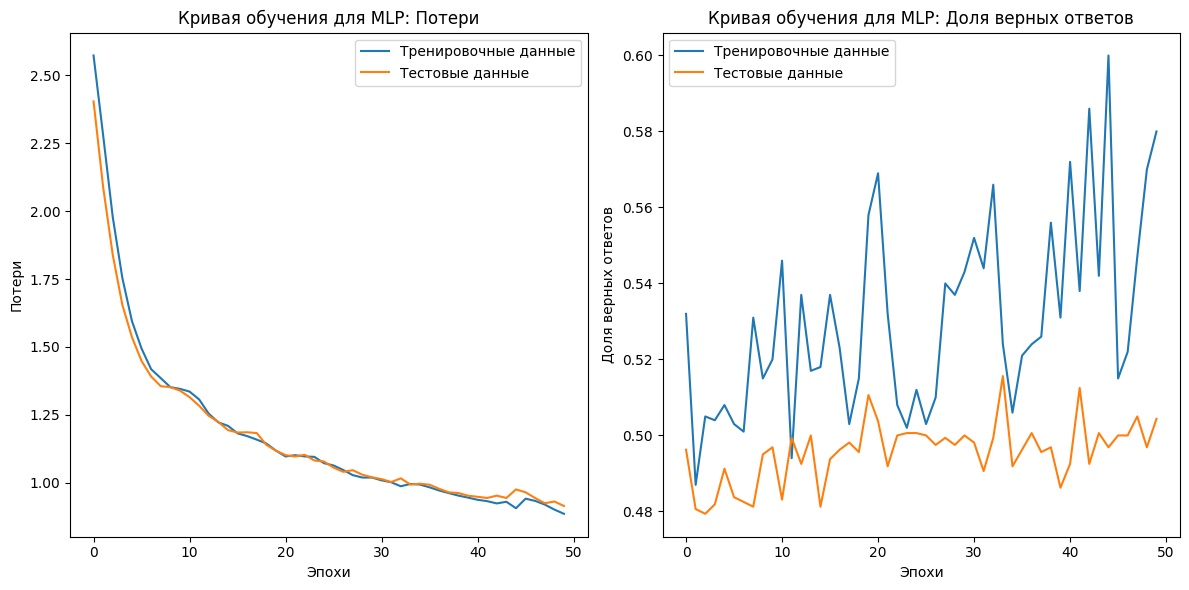

In [ ]:
# Графики для MLP
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='Тренировочные данные')
plt.plot(mlp_history.history['val_loss'], label='Тестовые данные')
plt.title('Кривая обучения для MLP: Потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='Тренировочные данные')
plt.plot(mlp_history.history['val_accuracy'], label='Тестовые данные')
plt.title('Кривая обучения для MLP: Доля верных ответов')
plt.xlabel('Эпохи')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.tight_layout()
plt.show()

Тут мы видим, что потери на тренировочном и тестовых наборах стабильно уменьшаются, а доля верных ответов +- увеличивается. Можно сказать, что модель ~ обучилась.

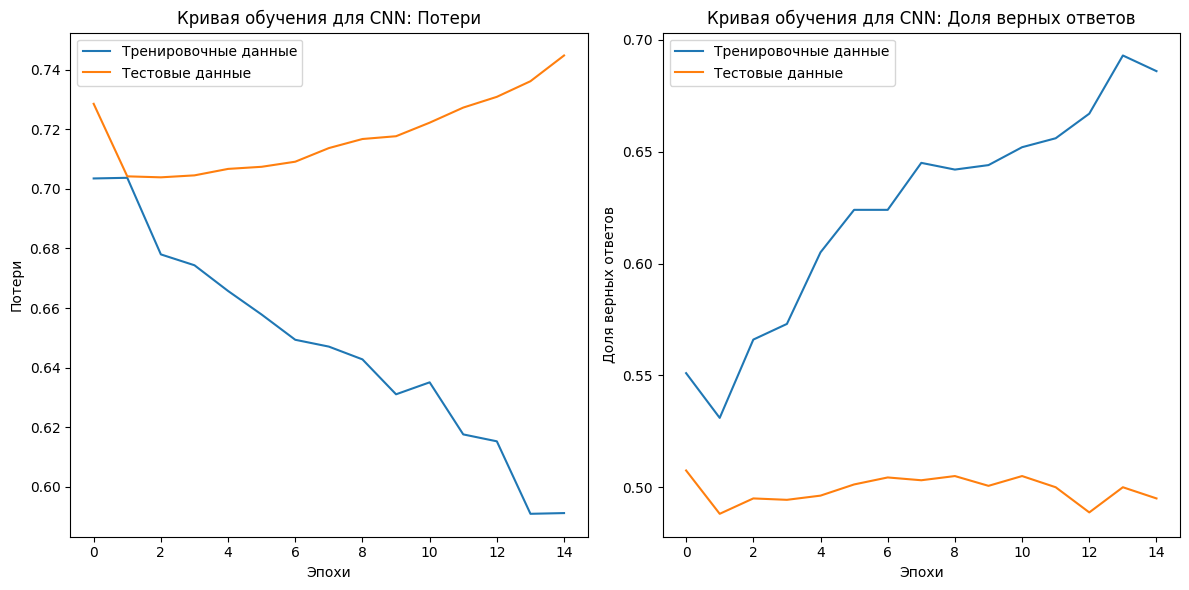

In [ ]:
# Графики для CNN
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Тренировочные данные')
plt.plot(cnn_history.history['val_loss'], label='Тестовые данные')
plt.title('Кривая обучения для CNN: Потери')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Тренировочные данные')
plt.plot(cnn_history.history['val_accuracy'], label='Тестовые данные')
plt.title('Кривая обучения для CNN: Доля верных ответов')
plt.xlabel('Эпохи')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.tight_layout()
plt.show()


Из графиков мы видим, что потери на тренировочном наборе уменьшаются, а на тестовом наоборот увеличиваются, что говорит о переобучении. Также с долей верных ответов - сначала на тренировочных данных accuracy росло, а потом на тестовых прекратило.

**Задание 5**  
Сравните качество бинарной классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

$$ Jaccard Index = \frac{TP}{TP + FP + FN} $$


In [ ]:
def evlt(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    if val_loss[-1] < train_loss[-1]:
        return "Недообучилась"
    elif val_loss[-1] > train_loss[-1] and (val_loss[-1] - train_loss[-1]) / val_loss[-1] > 0.1:
        return "Переобучилась"
    else:
        return "Обучилась"

mlp_status = evlt(mlp_history)
cnn_status = evlt(cnn_history)
print(f"MLP: {mlp_status}")
print(f"CNN: {cnn_status}")

# Печать метрик качества
jaccard_index = mlp_history.history['val_jaccard_index'][-1]
print(f"Коэффициент Жаккара на данных проверки: {jaccard_index:.4f}")

jaccard_index = cnn_history.history['val_jaccard_index'][-1]
print(f"Коэффициент Жаккара на данных проверки: {jaccard_index:.4f}")

MLP: Обучилась
CNN: Переобучилась
Коэффициент Жаккара на данных проверки: 0.3119
Коэффициент Жаккара на данных проверки: 0.3083


**Задание 6**  
Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.


Площадь под ROC кривой, обозначаемая $AUC$, может быть использована как мера качества классификатора. Так как общая площадь квадрата равна $1$, показатель $AUC$ находится в интервале $\left[0,\,1\right]$ (чем больше, тем лучше).

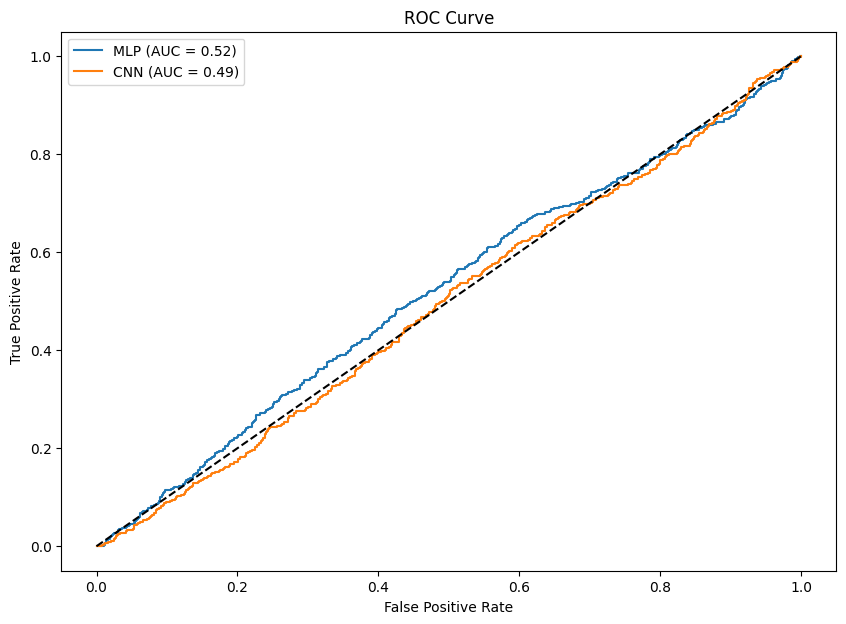

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
mlp_pred_probs = mlp_model.predict(test_images)
cnn_pred_probs = cnn_model.predict(test_images)

# Функция для построения ROC-кривой и вычисления AUC для одной модели
def plot_roc_curve(model_probs, y_true, label):
    # Вычисляем значения FPR (False Positive Rate), TPR (True Positive Rate) и пороги
    fpr, tpr, thresholds = roc_curve(y_true, model_probs)
    # Вычисляем AUC (Area Under the Curve)
    auc_score = roc_auc_score(y_true, model_probs)
    # Строим ROC-кривую для текущей модели
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

plt.figure(figsize=(10, 7))
plot_roc_curve(mlp_pred_probs, test_labels, label='MLP')
plot_roc_curve(cnn_pred_probs, test_labels, label='CNN')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
auc_mlp = roc_auc_score(test_labels, mlp_pred_probs)
auc_cnn = roc_auc_score(test_labels, cnn_pred_probs)

print("AUC для MLP:", auc_mlp)
print("AUC для CNN:", auc_cnn)


AUC для MLP: 0.5209375
AUC для CNN: 0.49425937500000006


**Задание 7**  
Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании).

In [ ]:
from tensorflow.keras.utils import to_categorical
train_mask = df_train['label'].isin([5, 7, 9]).copy()
test_mask = df_test['label'].isin([5, 7, 9]).copy()
df_train_filtered = df_train.loc[train_mask].copy()
df_test_filtered = df_test.loc[test_mask].copy()

label_map = {5: 0, 7: 1, 9: 2}
df_train_filtered.loc[:, 'label'] = df_train_filtered['label'].map(label_map)
df_test_filtered.loc[:, 'label'] = df_test_filtered['label'].map(label_map)

Метод to_categorical из модуля tensorflow.keras.utils используется для преобразования этих меток в формат "one-hot encoding". Аргумент 3 указывает количество классов (в данном случае, 3 класса).

In [ ]:
# Преобразование меток классов в one-hot формат
train_labels = to_categorical(df_train_filtered['label'], 3)
test_labels = to_categorical(df_test_filtered['label'], 3)

# Конвертация изображений и меток в numpy массивы
train_images = np.zeros(shape=(df_train_filtered.shape[0], 96, 96, 3), dtype=np.float32)
test_images = np.zeros(shape=(df_test_filtered.shape[0], 96, 96, 3), dtype=np.float32)

In [ ]:
for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train.iloc[idx]['image']))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test.iloc[idx]['image']))

train_images.shape, test_images.shape


((1500, 96, 96, 3), (2400, 96, 96, 3))

In [ ]:
# Нормализация изображений
train_images /= 255.0
test_images /= 255.0

In [ ]:

# MLP
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(96, 96, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(50, activation='elu', kernel_regularizer=tf.keras.regularizers.l2()),
    tf.keras.layers.Dense(40, activation='elu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

mlp_model.compile(optimizer='SGD',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_history = mlp_model.fit(train_images, train_labels, epochs=25,
                            validation_data=(test_images, test_labels))

test_loss_and_accuracy = mlp_model.evaluate(test_images, test_labels, verbose=1)
print(f"Точность на тестовых данных: {test_loss_and_accuracy[1]}")


Epoch 1/25
47/47 [==============================] - 6s 94ms/step - loss: 3.0046 - accuracy: 0.3260 - val_loss: 2.9609 - val_accuracy: 0.3383
Epoch 2/25
47/47 [==============================] - 2s 47ms/step - loss: 2.9430 - accuracy: 0.3313 - val_loss: 2.9339 - val_accuracy: 0.3346
Epoch 3/25
47/47 [==============================] - 1s 30ms/step - loss: 2.9048 - accuracy: 0.3467 - val_loss: 2.8849 - val_accuracy: 0.3404
Epoch 4/25
47/47 [==============================] - 2s 47ms/step - loss: 2.8652 - accuracy: 0.3807 - val_loss: 2.8539 - val_accuracy: 0.3325
Epoch 5/25
47/47 [==============================] - 1s 29ms/step - loss: 2.8302 - accuracy: 0.3827 - val_loss: 2.8327 - val_accuracy: 0.3350
Epoch 6/25
47/47 [==============================] - 1s 25ms/step - loss: 2.8017 - accuracy: 0.3600 - val_loss: 2.7917 - val_accuracy: 0.3404
Epoch 7/25
47/47 [==============================] - 1s 29ms/step - loss: 2.7622 - accuracy: 0.3807 - val_loss: 2.7597 - val_accuracy: 0.3442
Epoch 8/25
47

Видим, что потери уменьшаются, но доля верных ответов несильно растет.

In [ ]:
# CNN
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), input_shape=(96, 96, 3), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),

    tf.keras.layers.Conv2D(filters=16, kernel_size=(4,4), activation='tanh'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(50, activation='selu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(40, activation='selu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='sgd',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

cnn_history = cnn_model.fit(train_images, train_labels, epochs=10,
                            validation_data=(test_images, test_labels))

test_loss_and_accuracy = cnn_model.evaluate(test_images, test_labels, verbose=1)
print(f"Точность на тестовых данных: {test_loss_and_accuracy[1]}")

Epoch 1/10
47/47 [==============================] - 32s 589ms/step - loss: 1.2293 - accuracy: 0.3367 - val_loss: 1.1044 - val_accuracy: 0.3512
Epoch 2/10
47/47 [==============================] - 18s 379ms/step - loss: 1.1516 - accuracy: 0.3220 - val_loss: 1.0993 - val_accuracy: 0.3512
Epoch 3/10
47/47 [==============================] - 17s 366ms/step - loss: 1.1319 - accuracy: 0.3313 - val_loss: 1.0970 - val_accuracy: 0.3462
Epoch 4/10
47/47 [==============================] - 17s 370ms/step - loss: 1.1149 - accuracy: 0.3387 - val_loss: 1.1005 - val_accuracy: 0.3492
Epoch 5/10
47/47 [==============================] - 17s 373ms/step - loss: 1.1046 - accuracy: 0.3553 - val_loss: 1.0991 - val_accuracy: 0.3462
Epoch 6/10
47/47 [==============================] - 18s 375ms/step - loss: 1.1017 - accuracy: 0.3707 - val_loss: 1.0985 - val_accuracy: 0.3496
Epoch 7/10
47/47 [==============================] - 19s 410ms/step - loss: 1.1049 - accuracy: 0.3540 - val_loss: 1.0985 - val_accuracy: 0.3533

Потери уменьшаются, доля верных ответов почти не изменилась.

**Задание 8**  
Сравните качество многоклассовой классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

In [ ]:
mlp_pred_probs = mlp_model.predict(test_images)
cnn_pred_probs = cnn_model.predict(test_images)

mlp_pred = np.argmax(mlp_pred_probs, axis=1)
cnn_pred = np.argmax(cnn_pred_probs, axis=1)

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

mlp_confusion_matrix = confusion_matrix(test_labels.argmax(axis=1), mlp_pred)
cnn_confusion_matrix = confusion_matrix(test_labels.argmax(axis=1), cnn_pred)

mlp_precision = precision_score(test_labels.argmax(axis=1), mlp_pred, average='macro')
cnn_precision = precision_score(test_labels.argmax(axis=1), cnn_pred, average='macro')
print("Точность для MLP:", mlp_precision)
print("Точность для CNN:", cnn_precision)


75/75 [==============================] - 6s 77ms/step
Точность для MLP: 0.3386829490840233
Точность для CNN: 0.34456630919249953


Обе модели имеют низкую точность на текущем наборе данных. Точность MLP на тестовой выборке составляет ~34%, в то время как у CNN - 34.5%. Тем не менее, обе модели требуют дополнительного улучшения. В MLP даже используется регуляризация, но она несильно помогает. При изменении параметров обучения, таких как learning rate, оптимизатор и размер пакета, чтобы улучшить сходимость модели, все равно разница в обучении незначительная, к сожалению.

**Задание 9**  
Постройте кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

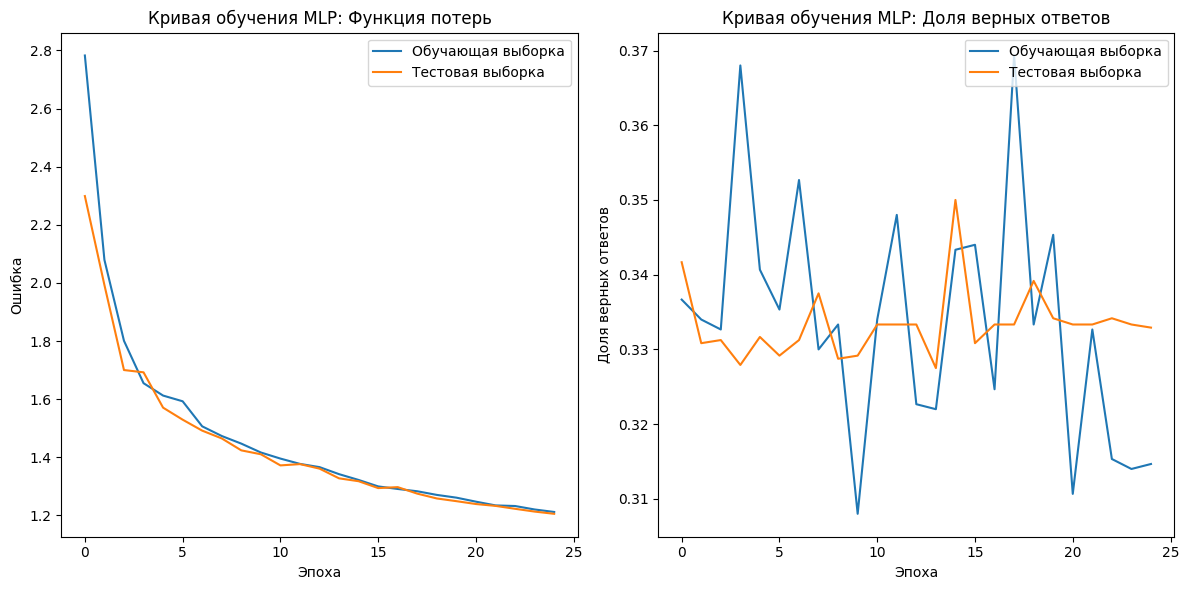

In [ ]:
# Построение кривых обучения для MLP
plt.figure(figsize=(12, 6))

# График ошибки
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='Обучающая выборка')
plt.plot(mlp_history.history['val_loss'], label='Тестовая выборка')
plt.title('Кривая обучения MLP: Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()

# График доли верных ответов
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['categorical_accuracy'], label='Обучающая выборка')
plt.plot(mlp_history.history['val_categorical_accuracy'], label='Тестовая выборка')
plt.title('Кривая обучения MLP: Доля верных ответов')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.tight_layout()
plt.show()

Видим, что потери стабильно уменьшаются, а доля верных ответов скачет. Увидели, что модель не очень хорошо обучилась.

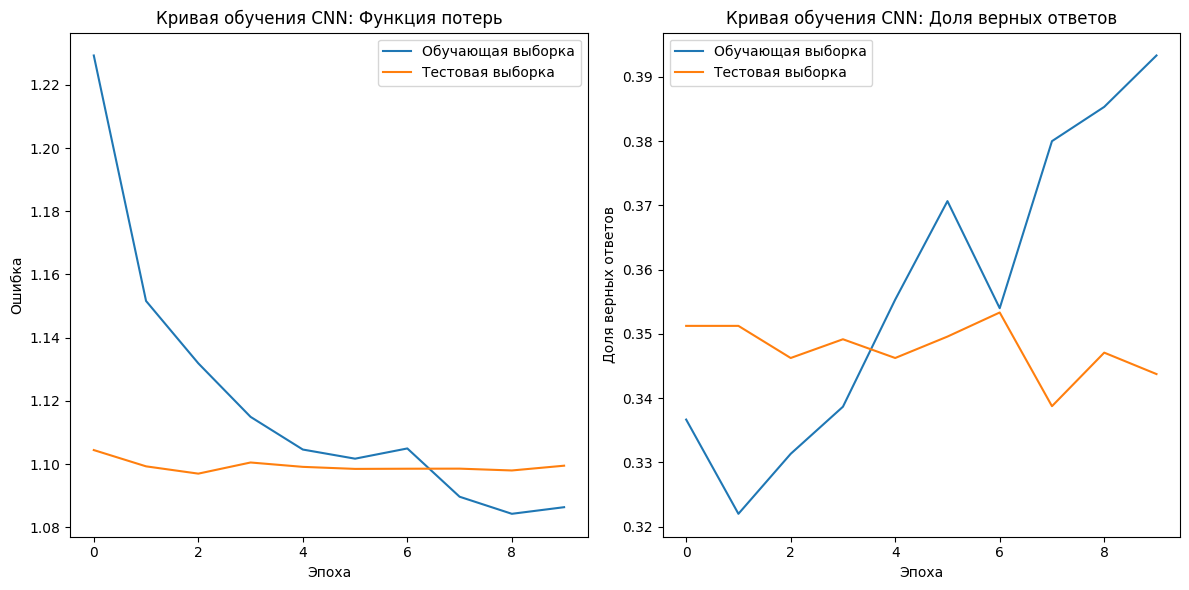

In [ ]:
# Построение кривых обучения для CNN
plt.figure(figsize=(12, 6))

# График ошибки
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Обучающая выборка')
plt.plot(cnn_history.history['val_loss'], label='Тестовая выборка')
plt.title('Кривая обучения CNN: Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()

# График доли верных ответов
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Обучающая выборка')
plt.plot(cnn_history.history['val_accuracy'], label='Тестовая выборка')
plt.title('Кривая обучения CNN: Доля верных ответов')
plt.xlabel('Эпоха')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.tight_layout()
plt.show()


Потери на обучающем наборе уменьшаются, но вот на тестовой выборке как-то не очень хорошо. Доля верных ответов на обучающем наборе сначала падает, но потом резко растет, а на тестовом наборе скачками по итогу уменьшилась.